## **Installing and loading modules**

In [1]:
!pip install torchviz  > /dev/null 2>&1
!pip install umap-learn > /dev/null 2>&1
!pip install scikit-optimize > /dev/null 2>&1

In [2]:
from Train import AE, train_AE, test_AE, set_global_seed, train_logistic_regression, train_ENet, train_MLP, count_dropping_subjects, save_pickle_object
from Plotting_Progression import plot_embedding_results, plot_progression_all_models, plot_violation_metrics, plot_subject_progression, plot_umap_embeddings
from Data_Preparation import data_preparation, demographic_information, compute_clf_metrics, prepare_data_EMCI_vs_AD_other_clf, prepare_data_EMCI_vs_AD, compute_violation_ratio_violation_gap, compute_violation_metrics

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint, uniform
import umap
import pickle

from google.colab import files


## **Data Preparation**

In [3]:
df = pd.read_csv(r"AV45_DX1234_all_preadjust_09272023.csv", parse_dates=["EXAMDATE"]).dropna().reset_index(drop=True)


continuous_df, continuous_cols, non_continuous_cols, modelling_cols, unique_subjects, train_data, test_data, \
X_train, X_test, y_train, y_test,  X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = data_preparation(df)

train_data_identifiers, test_data_identifiers = train_data[["AGE", "VISCODE2", "RID", "EXAMDATE"]].reset_index(drop = True), test_data[["AGE", "VISCODE2", "RID", "EXAMDATE"]].reset_index(drop = True)

train_data_scaled = pd.DataFrame(X_train)
test_data_scaled = pd.DataFrame(X_test)

columns_to_add = ["RID", "DXGrp", "AGE", "VISCODE2", "EXAMDATE"]
train_data_scaled[columns_to_add] = train_data[columns_to_add].reset_index(drop=True)

test_data_scaled[columns_to_add] = test_data[columns_to_add].reset_index(drop=True)

In [4]:
print(f'Number of unique subjects in train set : {train_data["RID"].nunique()}\nNumber of unique subjects in test set  :  {test_data["RID"].nunique()}')

Number of unique subjects in train set : 768
Number of unique subjects in test set  :  193


### ***Demographic Information About the Subjects***

In [5]:
demographic_information(df)

DXGrp,CN,EMCI,LMCI,AD
Subject,266,298,194,203
Gender,119/147,174/124,119/75,123/80
Age(mean±sd),74.879586 ± 6.994822,72.500268 ± 7.111645,74.778763 ± 8.154559,75.449015 ± 7.837887
Educ(mean±sd),16.530075 ± 2.503024,16.100671 ± 2.654632,16.097938 ± 2.825806,15.783251 ± 2.655522


### ***Model 1: Logistic Regression***

##### All model finetuning perfromed in ModelFinetuning.py

In [6]:
logreg_embedding_model, train_df_lr, test_df_lr = train_logistic_regression(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, train_data_identifiers, test_data_identifiers, train_data, test_data, plot_subject_progression, compute_violation_ratio_violation_gap)
lr_fig_test, lr_ax_test = plot_subject_progression(test_df_lr,  "Logistic Regression", "Normalized Logit", figsize=(8, 6))
vio_ratio_test_lr, vio_gap_test_lr = compute_violation_ratio_violation_gap(test_df_lr, 0)

### ***Model 2: Elastic Net***

In [7]:
ENet_embedding_model, train_df_en, test_df_en = train_ENet(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, train_data_identifiers, test_data_identifiers,train_data, test_data, plot_subject_progression, compute_violation_ratio_violation_gap)
en_fig_test, en_ax_test = plot_subject_progression(test_df_en, "Elastic Net", "Normalized Logit", figsize=(10, 8))
vio_ratio_test_en, vio_gap_test_en = compute_violation_ratio_violation_gap(test_df_en, 0)

### ***Model 3:  MLP***

In [8]:
MLP_embedding_model, train_df_mlp, test_df_mlp = train_MLP(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, train_data_identifiers, test_data_identifiers, train_data, test_data, plot_subject_progression, compute_violation_ratio_violation_gap, seed=42)
mlp_fig_test, mlp_ax_test = plot_subject_progression(test_df_mlp,  "MLP", "Normalized Logit", figsize=(10, 8))
vio_ratio_mlp, vio_gap_mlp = compute_violation_ratio_violation_gap(test_df_mlp, 0)

### ***Model 4: SLOPE Model***

Training for 1550 epochs with optimizer: <class 'torch.optim.adam.Adam'>, learning rate: 2.4430162614261403e-05



,epoch,total_loss,recon_loss,directional_loss
0,0,1.649367,1.005762,1.120755
1,50,1.521569,0.984680,1.021605
2,100,1.408957,0.950943,0.940225
3,150,1.309683,0.906366,0.873158
4,200,1.219276,0.848925,0.811577
5,250,1.128360,0.776956,0.749737
6,300,1.029182,0.686445,0.690764
7,350,0.933156,0.595290,0.637931
8,400,0.843594,0.504902,0.595421
9,450,0.768332,0.424459,0.556098


Metric,Reconstruction Loss,Directional Loss,Total Loss
Set,,,
Train,0.197335,0.277346,0.362275
Test,0.190186,0.730881,0.808708


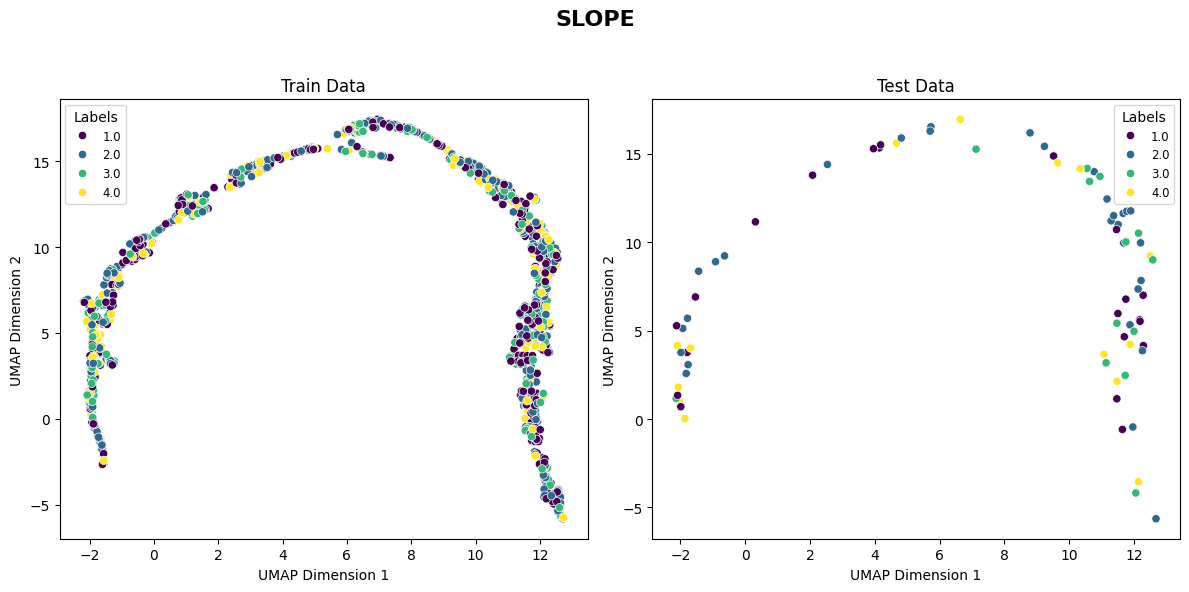

In [9]:
epochs = 1550
dims = [68, 286, 20, 286, 68]
activation = nn.ReLU
learning_rate = 2.4430162614261403e-05
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
lambda_reconstruction = 0.40921304830970556
lambda_directional = 1


torch.use_deterministic_algorithms(True)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_global_seed(42)


SLOPE_model = AE(dims=dims, activation=activation)

SLOPE_model, umap_model_SLOPE, SLOPE_train_umap, train_encoded_data_SLOPE, lhistory = train_AE(
    model = SLOPE_model,
    train_data=train_data,
    test_data=test_data,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    train_data_identifiers=train_data_identifiers,
    test_data_identifiers=test_data_identifiers,
    criterion = criterion,
    optimizer_class = optimizer,
    lr=learning_rate,
    epochs=epochs,
    lambda_reconstruction=lambda_reconstruction,
    lambda_directional=lambda_directional,
    directional_loss_enabled=True,
    continuous_df=continuous_df,
    return_losses=True
)
SLOPE_test_umap, test_encoded_data_SLOPE = test_AE(SLOPE_model,  X_test_tensor,  y_test_tensor, test_data_identifiers, umap_model_SLOPE)
plot_umap_embeddings(SLOPE_train_umap, SLOPE_test_umap, y_train, y_test, "SLOPE")

> After 1550 epochs, we have almost converged. The test loss does not reduce much after this.


### ***Model 5: Autoencoder Model- No Direction Loss***

Training for 1550 epochs with optimizer: <class 'torch.optim.adam.Adam'>, learning rate: 2.4430162614261403e-05



,epoch,total_loss,recon_loss
0,0,0.411571,1.005762
1,50,0.397453,0.971263
2,100,0.364754,0.891356
3,150,0.301324,0.736350
4,200,0.212934,0.520351
5,250,0.133323,0.325803
6,300,0.092528,0.226113
7,350,0.079671,0.194694
8,400,0.076035,0.185808
9,450,0.074810,0.182815


Metric,Reconstruction Loss,Directional Loss,Total Loss
Set,,,
Train,0.107712,0.0,0.044077
Test,0.109249,0.0,0.044706


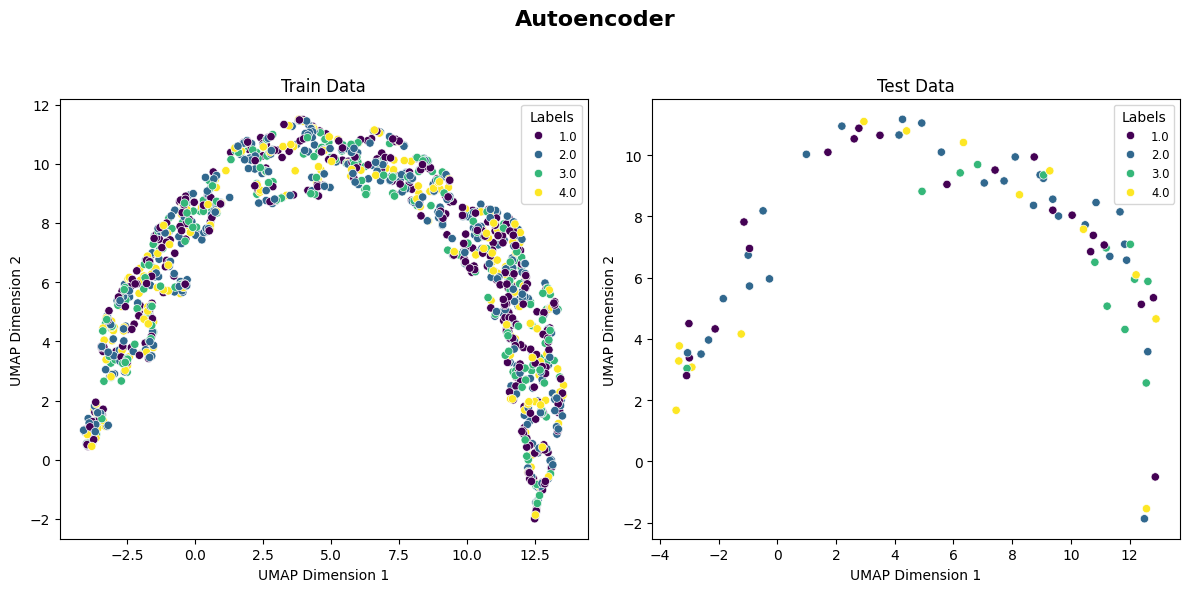

In [10]:
Autoencoder_model = AE(dims=dims, activation=activation)

Autoencoder_model, umap_model_Autoencoder, Autoencoder_train_umap, train_encoded_data_Autoencoder = train_AE(
    model = Autoencoder_model,
    train_data = train_data,
    test_data = test_data,
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_test_tensor = X_test_tensor,
    y_test_tensor = y_test_tensor,
    train_data_identifiers = train_data_identifiers,
    test_data_identifiers = test_data_identifiers,
    criterion = criterion,
    optimizer_class = optimizer,
    lr=learning_rate,
    epochs= epochs,
    lambda_reconstruction=lambda_reconstruction,
    lambda_directional=lambda_directional,
    directional_loss_enabled = False,
    continuous_df = continuous_df,
    return_losses=False

)

Autoencoder_test_umap, test_encoded_data_Autoencoder = test_AE(Autoencoder_model,  X_test_tensor,  y_test_tensor, test_data_identifiers, umap_model_Autoencoder)
plot_umap_embeddings(Autoencoder_train_umap, Autoencoder_test_umap, y_train, y_test, "Autoencoder")


**Note:**

> For learning pseudo-time, we need to use UMAP embeddings. We will use slingshot module from R programming. Place the files in "Supervised-Longitudinal-Progressive-Embedding/Embeddings" folder. We would have to read the following files in R:

- SLOPE_train_umap
- SLOPE_test_umap
- Autoencoder_train_umap
- Autoencoder_test_umap
- train_df_mlp.csv
- test_df_mlp.csv
- train_df_lr.csv
- test_df_lr.csv
- train_df_en.csv
- test_df_en.csv



Generate the plots and pseudotime computation and read them back in python.

> For downstream classification tasks, SLOPE/Autoencoder embeddings have to be used. Objects/files to be used:

- train_encoded_data_SLOPE
- test_encoded_data_SLOPE
- train_encoded_data_Autoencoder
- test_encoded_data_Autoencoder

In [11]:
SLOPE_train_umap.to_csv("SLOPE_train_umap.csv")
SLOPE_test_umap.to_csv("SLOPE_test_umap.csv")

Autoencoder_train_umap.to_csv("Autoencoder_train_umap.csv")
Autoencoder_test_umap.to_csv("Autoencoder_test_umap.csv")

umap_files = [
        "SLOPE_train_umap.csv",
        "SLOPE_test_umap.csv",
        "Autoencoder_train_umap.csv",
        "Autoencoder_test_umap.csv"    ]

for f in umap_files:
  files.download(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
supervised_files = [
    "train_df_mlp.csv",
    "test_df_mlp.csv",
    "train_df_lr.csv",
    "test_df_lr.csv",
    "train_df_en.csv",
    "test_df_en.csv"]



train_df_lr.to_csv("train_df_lr.csv")
test_df_lr.to_csv("test_df_lr.csv")
train_df_en.to_csv("train_df_en.csv")
test_df_en.to_csv("test_df_en.csv")
train_df_mlp.to_csv("train_df_mlp.csv")
test_df_mlp.to_csv("test_df_mlp.csv")



for f in supervised_files:
  files.download(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# We need the encodings for classification task

np.save("train_encoded_data_SLOPE.npy", train_encoded_data_SLOPE)
np.save("test_encoded_data_SLOPE.npy", test_encoded_data_SLOPE)
np.save("train_encoded_data_Autoencoder.npy", train_encoded_data_Autoencoder)
np.save("test_encoded_data_Autoencoder.npy", test_encoded_data_Autoencoder)

encoding_files= [
"train_encoded_data_SLOPE.npy",
"test_encoded_data_SLOPE.npy",
"train_encoded_data_Autoencoder.npy",
"test_encoded_data_Autoencoder.npy"
]



for f in encoding_files:
  files.download(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Checking weights are different for the models
# They should be different
state_dict_SLOPE = SLOPE_model.state_dict()
state_dict_Autoencoder = Autoencoder_model.state_dict()

print("Comparing weights layer by layer")
print()
for key in state_dict_SLOPE.keys():
    SLOPE_weights = state_dict_SLOPE[key]
    Autoencoder_weights = state_dict_Autoencoder[key]

    if torch.equal(SLOPE_weights, Autoencoder_weights):
        print(f"Layer {key}: Weights are the SAME.")
    else:
        print(f"Layer {key}: Weights are DIFFERENT.")
print()

SLOPE_save_path = "SLOPE_state_dict.pth"
Autoencoder_save_path = "Autoencoder_state_dict.pth"

# Saving the model's state dictionary
torch.save(SLOPE_model.state_dict(), SLOPE_save_path)
torch.save(Autoencoder_model.state_dict(), Autoencoder_save_path)

print(f"SLOPE Model's state dictionary saved at {SLOPE_save_path}")
print(f"Autoencoder Model's state dictionary saved at {Autoencoder_save_path}")
print()

files.download(SLOPE_save_path)
files.download(Autoencoder_save_path)

print("State dictionaries saved successfully!!")

Comparing weights layer by layer

Layer encoder.0.weight: Weights are DIFFERENT.
Layer encoder.0.bias: Weights are DIFFERENT.
Layer encoder.2.weight: Weights are DIFFERENT.
Layer encoder.2.bias: Weights are DIFFERENT.
Layer decoder.0.weight: Weights are DIFFERENT.
Layer decoder.0.bias: Weights are DIFFERENT.
Layer decoder.2.weight: Weights are DIFFERENT.
Layer decoder.2.bias: Weights are DIFFERENT.

SLOPE Model's state dictionary saved at SLOPE_state_dict.pth
Autoencoder Model's state dictionary saved at Autoencoder_state_dict.pth



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State dictionaries saved successfully!!


> Weights are different!

## Reloading the Models

In [15]:
epochs = 1550
dims = [68, 286, 20, 286, 68]
activation = nn.ReLU
learning_rate = 2.4430162614261403e-05
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
lambda_reconstruction = 0.40921304830970556
lambda_directional = 1

SLOPE_model_reloaded = AE(dims= dims, activation= activation)
Autoencoder_model_reloaded = AE(dims= dims, activation= activation)

SLOPE_model_reloaded.load_state_dict(torch.load("/content/SLOPE_state_dict.pth"))
Autoencoder_model_reloaded.load_state_dict(torch.load("/content/Autoencoder_state_dict.pth"))


<All keys matched successfully>

## Reading Embeddings from SLOPE, Autoencoder & Supervised Models

In [60]:
!rm -rf SLOPE_train_plots.png \
SLOPE_test_plots.png \
Autoencoder_train_plots.png \
Plot1_train_vs_pseudotime_Autoencoder.png \
Autoencoder_test_plots.png \
Supervised_train_plots.png \
Supervised_test_plots.png \
SLOPE_Pseudotime_train.csv \
SLOPE_Pseudotime_test.csv \
Autoencoder_Pseudotime_train.csv \
Autoencoder_Pseudotime_test.csv \
train_encodings_umap_SLOPE.csv \
test_encodings_umap_SLOPE.csv \
train_encodings_umap_Autoencoder.csv \
test_encodings_umap_Autoencoder.csv \


uploaded = files.upload()

Psuedotime_train_SLOPE = pd.read_csv("SLOPE_Pseudotime_train.csv").sort_values(["AGE", "RID"])
Psuedotime_test_SLOPE = pd.read_csv("SLOPE_Pseudotime_test.csv").sort_values(["AGE", "RID"])

Psuedotime_train_Autoencoder = pd.read_csv("Autoencoder_Pseudotime_train.csv").sort_values(["AGE", "RID"])
Psuedotime_test_Autoencoder = pd.read_csv("Autoencoder_Pseudotime_test.csv").sort_values(["AGE", "RID"])


Saving Autoencoder_Pseudotime_test.csv to Autoencoder_Pseudotime_test.csv
Saving Autoencoder_Pseudotime_train.csv to Autoencoder_Pseudotime_train.csv
Saving Autoencoder_test_plots.png to Autoencoder_test_plots.png
Saving Autoencoder_train_plots.png to Autoencoder_train_plots.png
Saving SLOPE_Pseudotime_test.csv to SLOPE_Pseudotime_test.csv
Saving SLOPE_Pseudotime_train.csv to SLOPE_Pseudotime_train.csv
Saving SLOPE_test_plots.png to SLOPE_test_plots.png
Saving SLOPE_train_plots.png to SLOPE_train_plots.png
Saving Supervised_test_plots.png to Supervised_test_plots.png
Saving Supervised_train_plots.png to Supervised_train_plots.png


### ***Visualizing Results***

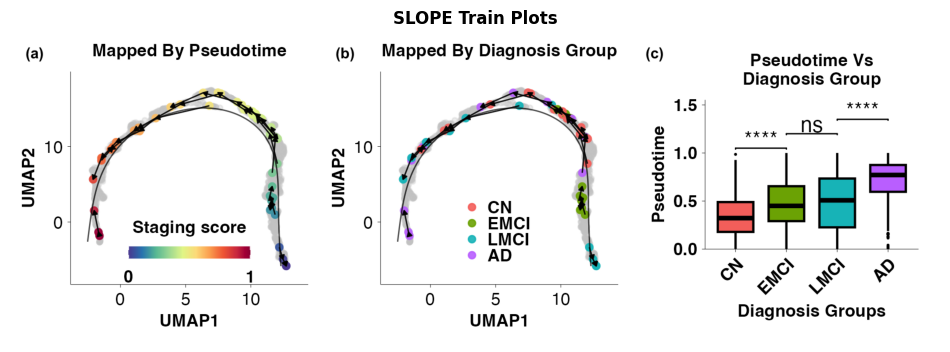

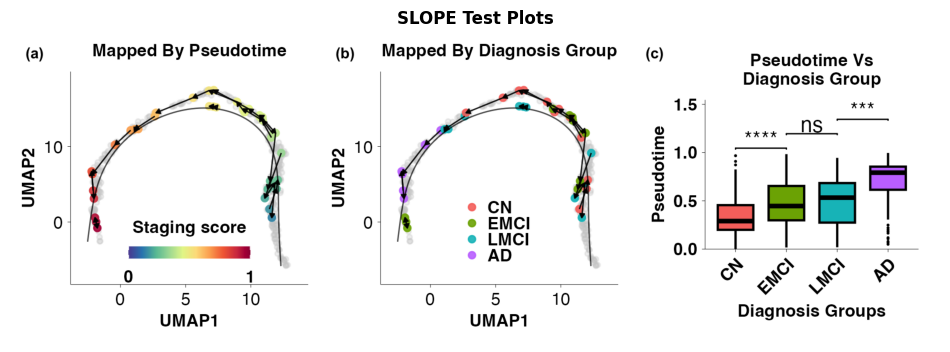

In [61]:
plot_embedding_results("SLOPE_train_plots.png", title="SLOPE Train Plots", figsize = (12, 8))
print()
plot_embedding_results("SLOPE_test_plots.png", title="SLOPE Test Plots", figsize = (12, 8))


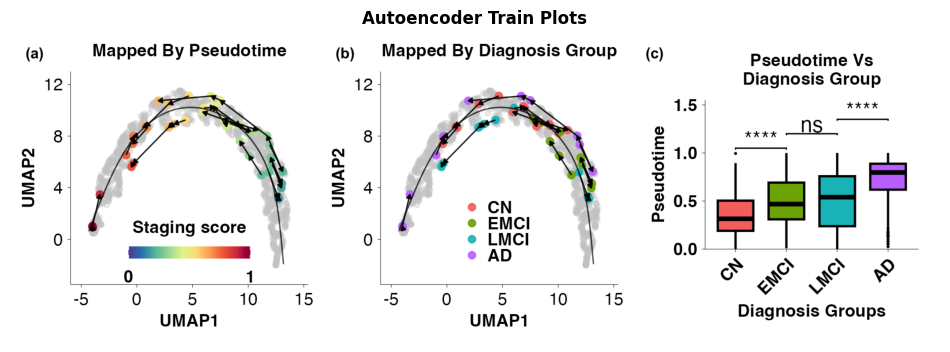

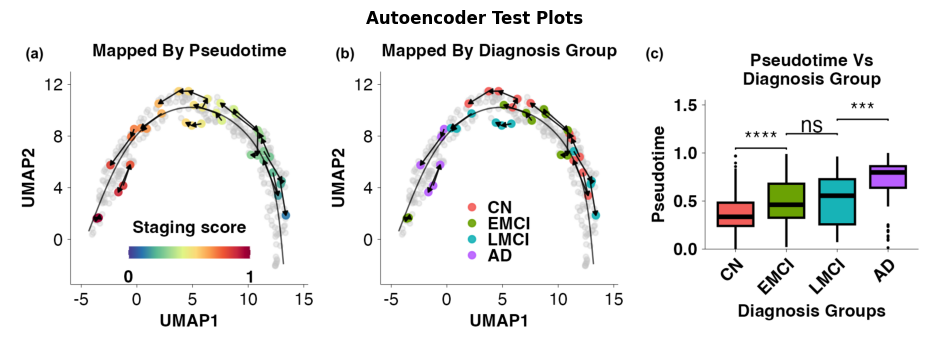

In [62]:
plot_embedding_results("Autoencoder_train_plots.png", title="Autoencoder Train Plots", figsize = (12, 8))
print()
plot_embedding_results("Autoencoder_test_plots.png", title="Autoencoder Test Plots", figsize = (12, 8))


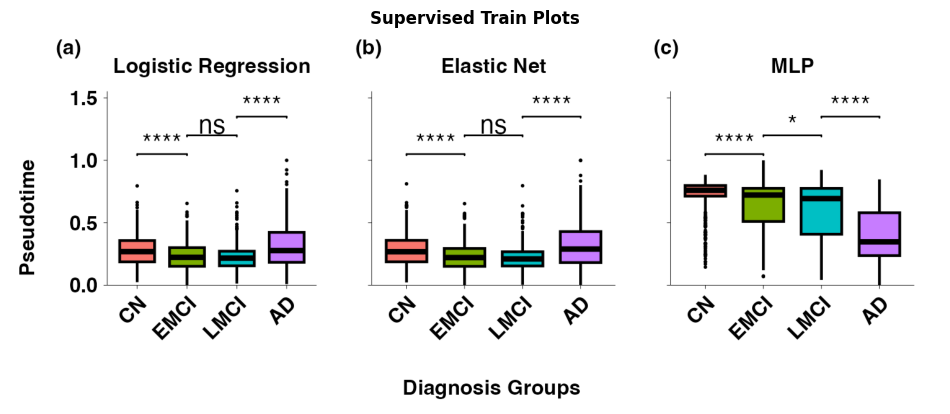

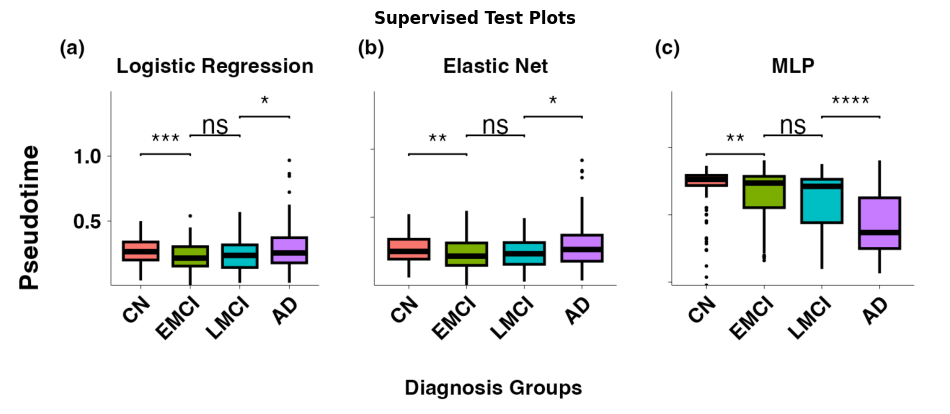

In [63]:
plot_embedding_results("Supervised_train_plots.png", title="Supervised Train Plots", figsize = (12, 8))
print()
plot_embedding_results("Supervised_test_plots.png", title="Supervised Test Plots", figsize = (12, 8))


In [64]:
dropping_subjects_train_SLOPE = count_dropping_subjects(Psuedotime_train_SLOPE, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_train_Autoencoder = count_dropping_subjects(Psuedotime_train_Autoencoder, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_train_lr = count_dropping_subjects(train_df_lr, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_train_en = count_dropping_subjects(train_df_en, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_train_mlp = count_dropping_subjects(train_df_mlp, "RID", "AGE", "Pseudotime_Normalized")

print("Train set:")
print("Dropping subjects SLOPE: ", dropping_subjects_train_SLOPE)
print("Dropping subjects Autoencoder: ", dropping_subjects_train_Autoencoder)
print("Dropping subjects Logistic Regression: ", dropping_subjects_train_lr)
print("Dropping subjects Elastic Net: ", dropping_subjects_train_en)
print("Dropping subjects MLP: ", dropping_subjects_train_mlp)


dropping_subjects_test_SLOPE = count_dropping_subjects(Psuedotime_test_SLOPE, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_test_Autoencoder = count_dropping_subjects(Psuedotime_test_Autoencoder, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_test_lr = count_dropping_subjects(test_df_lr, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_test_en = count_dropping_subjects(test_df_en, "RID", "AGE", "Pseudotime_Normalized")
dropping_subjects_test_mlp = count_dropping_subjects(test_df_mlp, "RID", "AGE", "Pseudotime_Normalized")

print()
print("Test set:")
print("Dropping subjects SLOPE: ", dropping_subjects_test_SLOPE)
print("Dropping subjects Autoencoder: ", dropping_subjects_test_Autoencoder)
print("Dropping subjects Logistic Regression: ", dropping_subjects_test_lr)
print("Dropping subjects Elastic Net: ", dropping_subjects_test_en)
print("Dropping subjects MLP: ", dropping_subjects_test_mlp)


Train set:
Dropping subjects SLOPE:  211
Dropping subjects Autoencoder:  239
Dropping subjects Logistic Regression:  300
Dropping subjects Elastic Net:  299
Dropping subjects MLP:  77

Test set:
Dropping subjects SLOPE:  47
Dropping subjects Autoencoder:  56
Dropping subjects Logistic Regression:  76
Dropping subjects Elastic Net:  79
Dropping subjects MLP:  86


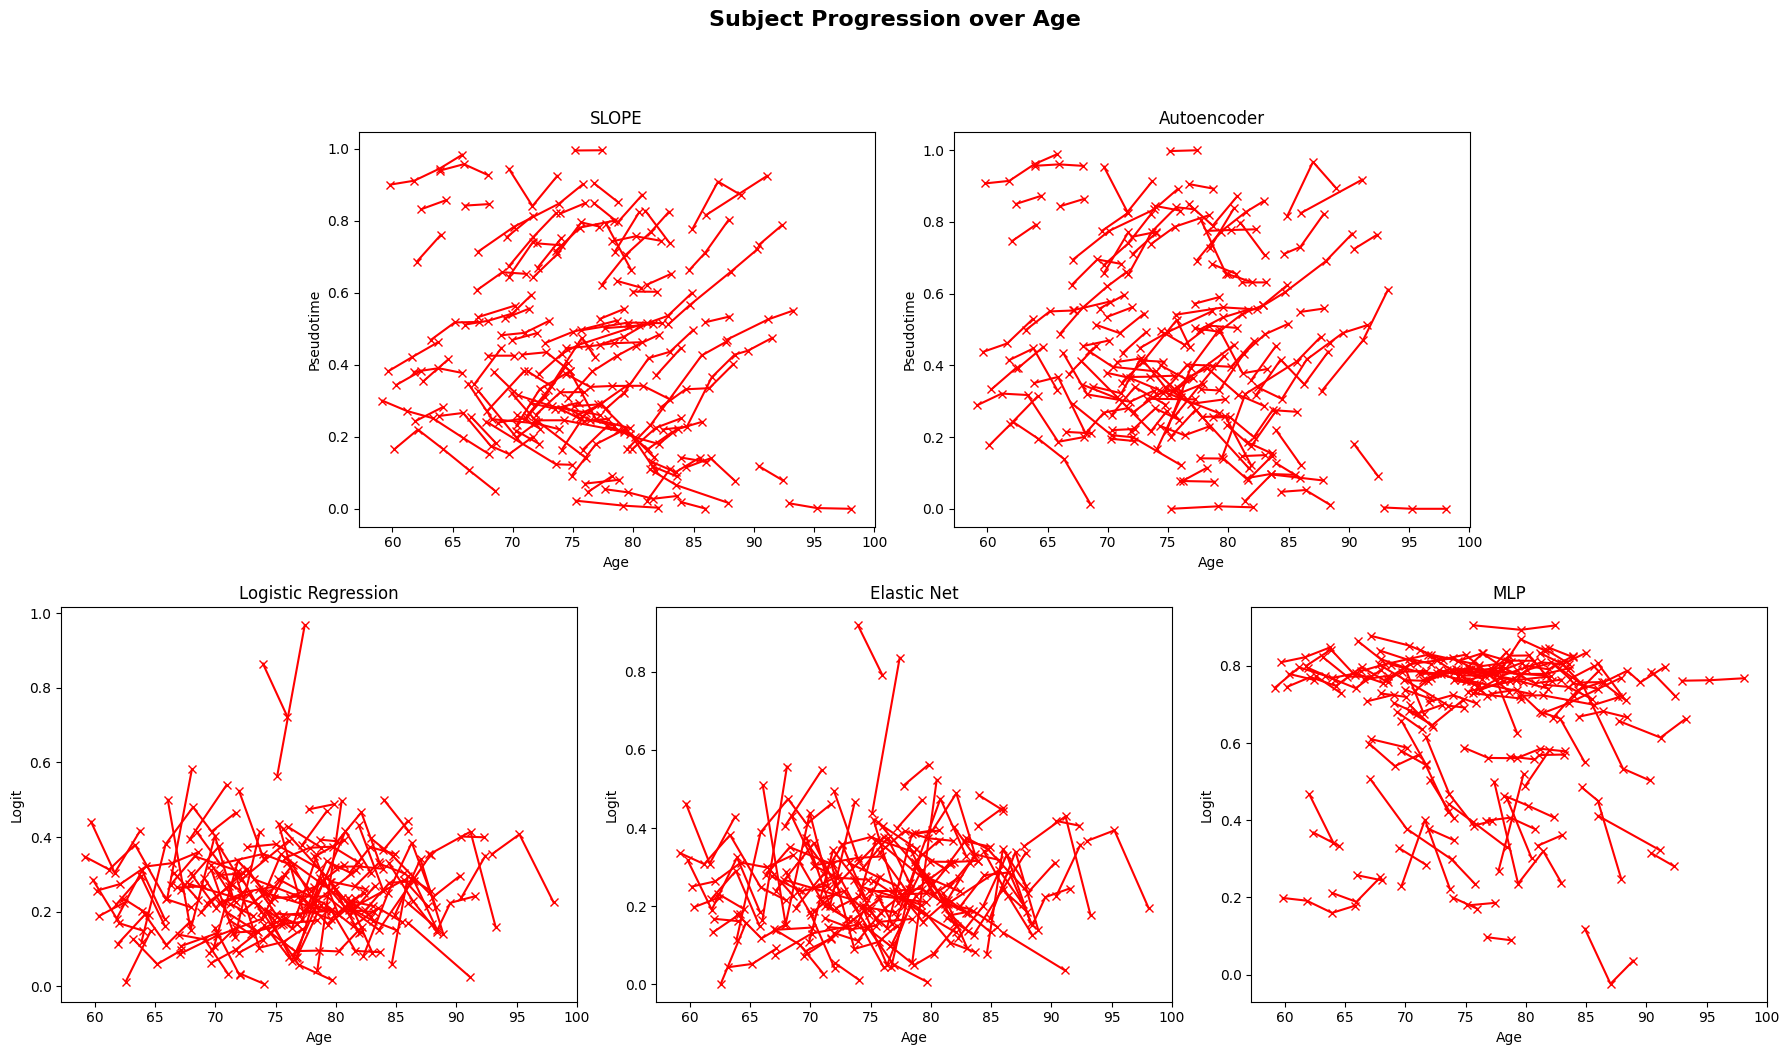

In [25]:
SLOPE_fig_test, SLOPE_ax_test = plot_subject_progression(Psuedotime_test_SLOPE,  "SLOPE", "Psuedotime", figsize =  (8, 6))
Autoencoder_fig_test, Autoencoder_ax_test = plot_subject_progression(Psuedotime_test_Autoencoder, "Autoencoder", "Psuedotime" ,figsize =  (8, 6))

plot_progression_all_models(
    [
        (SLOPE_fig_test, SLOPE_ax_test),
        (Autoencoder_fig_test, Autoencoder_ax_test),
        (lr_fig_test, lr_ax_test),
        (en_fig_test, en_ax_test),
        (mlp_fig_test, mlp_ax_test)
    ]
)

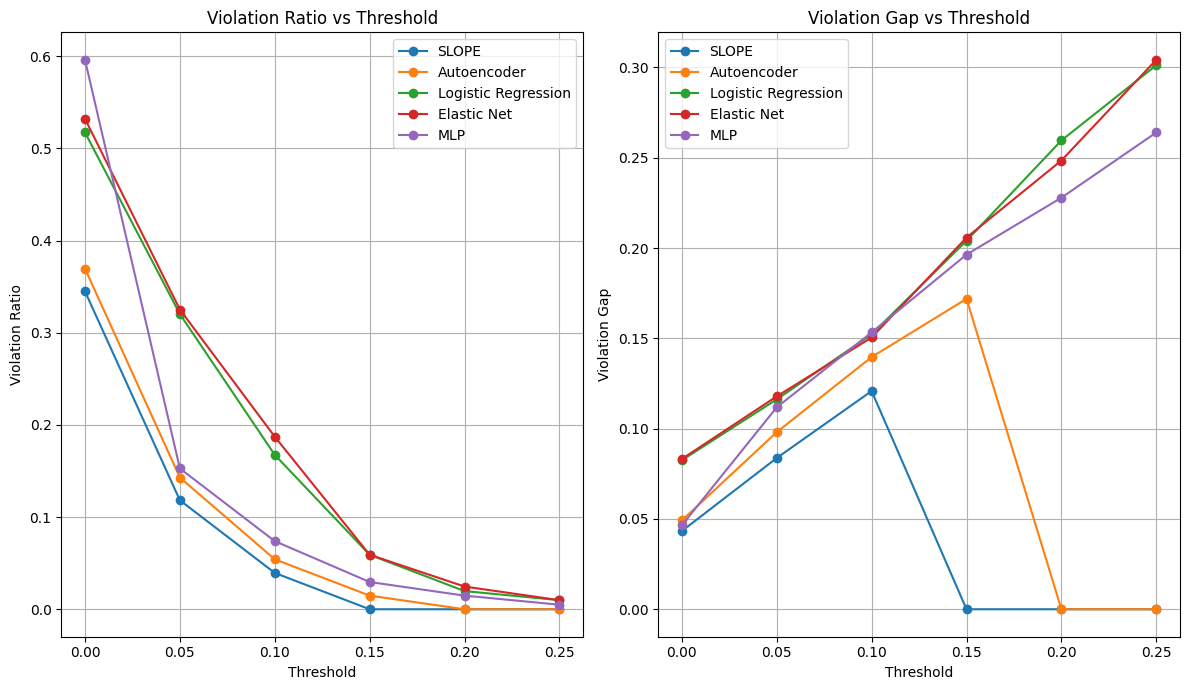

In [26]:
test_psuedotime_models = {
    'SLOPE': Psuedotime_test_SLOPE,
    'Autoencoder': Psuedotime_test_Autoencoder,
    'Logistic Regression': test_df_lr,
    'Elastic Net': test_df_en,
    'MLP': test_df_mlp
}
thresholds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]

results_violation_ratio_and_gap = compute_violation_metrics(test_psuedotime_models, thresholds)
plot_violation_metrics(results_violation_ratio_and_gap, thresholds, figsize = (12, 7))

# **CN vs AD Classification**

Models prepared for three different embeddings :



*   SLOPE embeddings
*   Autoencoder embeddings
*   Embeddings from original data or simply raw data.

Models tested:



1.   Logistic Regression
2.   Elastic Net
3.   MLP




## Data Preparation: CN Vs AD

In [27]:
# Reload embeddings
train_encoded_data_SLOPE_loaded = np.load("train_encoded_data_SLOPE.npy")
test_encoded_data_SLOPE_loaded = np.load("test_encoded_data_SLOPE.npy")
train_encoded_data_Autoencoder_loaded = np.load("train_encoded_data_Autoencoder.npy")
test_encoded_data_Autoencoder_loaded = np.load("test_encoded_data_Autoencoder.npy")

In [28]:
## SLOPE Embeddings
X_train_encoded_data_SLOPE_CN_vs_AD, y_train_encoded_data_SLOPE_CN_vs_AD, train_encoded_data_SLOPE_CN_vs_AD = prepare_data_EMCI_vs_AD(
    train_data_scaled, train_encoded_data_SLOPE, target_column='DXGrp', id_column='RID',
    date_column='EXAMDATE', target_classes=[1, 4]
)

X_test_encoded_data_SLOPE_CN_vs_AD, y_test_encoded_data_SLOPE_CN_vs_AD, test_encoded_data_SLOPE_CN_vs_AD = prepare_data_EMCI_vs_AD(
    test_data_scaled, test_encoded_data_SLOPE, target_column='DXGrp', id_column='RID',
    date_column='EXAMDATE', target_classes=[1, 4]
)

scaler_slope = StandardScaler()
X_train_encoded_data_SLOPE_CN_vs_AD = scaler_slope.fit_transform(X_train_encoded_data_SLOPE_CN_vs_AD)
X_test_encoded_data_SLOPE_CN_vs_AD = scaler_slope.transform(X_test_encoded_data_SLOPE_CN_vs_AD)


## Autoencoder Embeddings
X_train_encoded_data_Autoencoder_CN_vs_AD, y_train_encoded_data_Autoencoder_CN_vs_AD, train_encoded_data_Autoencoder_CN_vs_AD = prepare_data_EMCI_vs_AD(
    train_data_scaled, train_encoded_data_Autoencoder, target_column='DXGrp', id_column='RID',
    date_column='EXAMDATE', target_classes=[1, 4]
)

X_test_encoded_data_Autoencoder_CN_vs_AD, y_test_encoded_data_Autoencoder_CN_vs_AD, test_encoded_data_Autoencoder_CN_vs_AD = prepare_data_EMCI_vs_AD(
    test_data_scaled, test_encoded_data_Autoencoder, target_column='DXGrp', id_column='RID',
    date_column='EXAMDATE', target_classes=[1, 4]
)


scaler_autoencoder = StandardScaler()
X_train_encoded_data_Autoencoder_CN_vs_AD = scaler_autoencoder.fit_transform(X_train_encoded_data_Autoencoder_CN_vs_AD)
X_test_encoded_data_Autoencoder_CN_vs_AD = scaler_autoencoder.transform(X_test_encoded_data_Autoencoder_CN_vs_AD)


# Original data
X_train_encoded_data_Original_CN_vs_AD, y_train_encoded_data_Original_CN_vs_AD, train_encoded_data_Original_CN_vs_AD = prepare_data_EMCI_vs_AD_other_clf(
    train_data_scaled,  target_column='DXGrp', id_column='RID',
    date_column='EXAMDATE', target_classes=[1, 4]
)


X_test_encoded_data_Original_CN_vs_AD, y_test_encoded_data_Original_CN_vs_AD, test_encoded_data_Original_CN_vs_AD = prepare_data_EMCI_vs_AD_other_clf(
    test_data_scaled,  target_column='DXGrp', id_column='RID',
    date_column='EXAMDATE', target_classes=[1, 4]
)

scaler_original = StandardScaler()
X_train_encoded_data_Original_CN_vs_AD = scaler_original.fit_transform(X_train_encoded_data_Original_CN_vs_AD)
X_test_encoded_data_Original_CN_vs_AD = scaler_original.transform(X_test_encoded_data_Original_CN_vs_AD)


### **Model Configuration**

In [58]:
cv = 5
verbose = 2
n_iter = 200
n_jobs = -1
scoring = 'balanced_accuracy'
random_state = 42

### ***1. Logistic Regression***

In [44]:
param_grid_lr = {
    'C': uniform(0.01, 100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': randint(100, 2000),
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'fit_intercept': [True, False],
}


#### ***SLOPE***

In [45]:
random_search_logreg_SLOPE = RandomizedSearchCV(
    estimator = LogisticRegression(random_state=42),
    param_distributions = param_grid_lr,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)


random_search_logreg_SLOPE.fit(X_train_encoded_data_SLOPE_CN_vs_AD, y_train_encoded_data_SLOPE_CN_vs_AD)

finetuned_logreg_SLOPE = random_search_logreg_SLOPE.best_estimator_

y_train_pred_logreg_SLOPE = finetuned_logreg_SLOPE.predict(X_train_encoded_data_SLOPE_CN_vs_AD)
y_test_pred_logreg_SLOPE = finetuned_logreg_SLOPE.predict(X_test_encoded_data_SLOPE_CN_vs_AD)

lr_train_metrics_SLOPE = compute_clf_metrics(y_train_encoded_data_SLOPE_CN_vs_AD, y_train_pred_logreg_SLOPE)
lr_test_metrics_SLOPE = compute_clf_metrics(y_test_encoded_data_SLOPE_CN_vs_AD, y_test_pred_logreg_SLOPE)


results_logreg_SLOPE = pd.DataFrame([lr_test_metrics_SLOPE],
                          index=[ 'SLOPE + Logistic Regression']).round(3)

display(results_logreg_SLOPE)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
SLOPE + Logistic Regression,0.841,0.858,0.858


#### ***Autoencoder***

In [46]:
random_search_logreg_Autoencoder = RandomizedSearchCV(
    estimator = LogisticRegression(random_state=42),
    param_distributions = param_grid_lr,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)

random_search_logreg_Autoencoder.fit(X_train_encoded_data_Autoencoder_CN_vs_AD, y_train_encoded_data_Autoencoder_CN_vs_AD)

finetuned_logreg_Autoencoder = random_search_logreg_Autoencoder.best_estimator_



y_train_pred_logreg_Autoencoder = finetuned_logreg_Autoencoder.predict(X_train_encoded_data_Autoencoder_CN_vs_AD)
y_test_pred_logreg_Autoencoder = finetuned_logreg_Autoencoder.predict(X_test_encoded_data_Autoencoder_CN_vs_AD)

lr_train_metrics_Autoencoder = compute_clf_metrics(y_train_encoded_data_Autoencoder_CN_vs_AD, y_train_pred_logreg_Autoencoder)
lr_test_metrics_Autoencoder = compute_clf_metrics(y_test_encoded_data_Autoencoder_CN_vs_AD, y_test_pred_logreg_Autoencoder)


results_logreg_Autoencoder = pd.DataFrame([lr_test_metrics_Autoencoder],
                          index=[ 'Autoencoder + Logistic Regression']).round(3)

display(results_logreg_Autoencoder)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
Autoencoder + Logistic Regression,0.814,0.836,0.836


#### ***Original***

In [47]:

random_search_logreg_Original = RandomizedSearchCV(
    estimator = LogisticRegression(random_state=42),
    param_distributions = param_grid_lr,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)

random_search_logreg_Original.fit(X_train_encoded_data_Original_CN_vs_AD, y_train_encoded_data_Original_CN_vs_AD)

finetuned_logreg_Original = random_search_logreg_Original.best_estimator_


y_train_pred_logreg = finetuned_logreg_Original.predict(X_train_encoded_data_Original_CN_vs_AD)
y_test_pred_logreg = finetuned_logreg_Original.predict(X_test_encoded_data_Original_CN_vs_AD)

lr_train_metrics_other = compute_clf_metrics(y_train_encoded_data_Original_CN_vs_AD, y_train_pred_logreg)
lr_test_metrics_other = compute_clf_metrics(y_test_encoded_data_Original_CN_vs_AD, y_test_pred_logreg)


results_logreg_Original = pd.DataFrame([lr_test_metrics_other],
                          index=[ 'Original + Logistic Regression']).round(3)

display(results_logreg_Original)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
Original + Logistic Regression,0.762,0.794,0.794


### ***2. Elastic Net***

In [48]:
param_grid_enet = {
    'C': uniform(0.05, 100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1_ratio': np.linspace(0, 1, 20),
    'fit_intercept': [True, False],
}

#### ***SLOPE***

In [49]:

random_search_ENet_SLOPE = RandomizedSearchCV(
    estimator = LogisticRegression(penalty='elasticnet', random_state=42),
    param_distributions = param_grid_enet,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)

random_search_ENet_SLOPE.fit(X_train_encoded_data_SLOPE_CN_vs_AD, y_train_encoded_data_SLOPE_CN_vs_AD)

finetuned_ENet_SLOPE = random_search_ENet_SLOPE.best_estimator_

y_train_pred_en_SLOPE = finetuned_ENet_SLOPE.predict(X_train_encoded_data_SLOPE_CN_vs_AD)
y_test_pred_en_SLOPE = finetuned_ENet_SLOPE.predict(X_test_encoded_data_SLOPE_CN_vs_AD)

en_train_metrics_SLOPE = compute_clf_metrics(y_train_encoded_data_SLOPE_CN_vs_AD, y_train_pred_en_SLOPE)
en_test_metrics_SLOPE = compute_clf_metrics(y_test_encoded_data_SLOPE_CN_vs_AD, y_test_pred_en_SLOPE)

results_ENet_SLOPE = pd.DataFrame([en_test_metrics_SLOPE],
                                     index=['SLOPE + Elastic Net']).round(3)

display(results_ENet_SLOPE)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
SLOPE + Elastic Net,0.841,0.858,0.858


#### ***Autoencoder***

In [50]:
random_search_ENet_Autoencoder = RandomizedSearchCV(
    estimator = LogisticRegression(penalty='elasticnet', random_state=42),
    param_distributions = param_grid_enet,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)

random_search_ENet_Autoencoder.fit(X_train_encoded_data_Autoencoder_CN_vs_AD, y_train_encoded_data_Autoencoder_CN_vs_AD)

finetuned_ENet_Autoencoder = random_search_ENet_Autoencoder.best_estimator_

y_train_pred_en_Autoencoder = finetuned_ENet_Autoencoder.predict(X_train_encoded_data_Autoencoder_CN_vs_AD)
y_test_pred_en_Autoencoder = finetuned_ENet_Autoencoder.predict(X_test_encoded_data_Autoencoder_CN_vs_AD)

train_metrics_en_Autoencoder = compute_clf_metrics(y_train_encoded_data_Autoencoder_CN_vs_AD, y_train_pred_en_Autoencoder)
test_metrics_en_Autoencoder = compute_clf_metrics(y_test_encoded_data_Autoencoder_CN_vs_AD, y_test_pred_en_Autoencoder)

results_ENet_Autoencoder = pd.DataFrame([test_metrics_en_Autoencoder],
                                        index=['Autoencoder + Elastic Net']).round(3)

display(results_ENet_Autoencoder)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
Autoencoder + Elastic Net,0.814,0.836,0.836


### ***Original***



In [51]:
random_search_ENet_Original = RandomizedSearchCV(
    estimator = LogisticRegression(penalty='elasticnet', random_state = random_state),
    param_distributions = param_grid_enet,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_stat = 42,
    scoring = scoring
)

random_search_ENet_Original.fit(X_train_encoded_data_Original_CN_vs_AD, y_train_encoded_data_Original_CN_vs_AD)

finetuned_ENet_Original = random_search_ENet_Original.best_estimator_



y_train_pred_en_Original = finetuned_ENet_Original.predict(X_train_encoded_data_Original_CN_vs_AD)
y_test_pred_en_Original = finetuned_ENet_Original.predict(X_test_encoded_data_Original_CN_vs_AD)

en_train_metrics_Original = compute_clf_metrics(y_train_encoded_data_Original_CN_vs_AD, y_train_pred_en_Original)
en_test_metrics_Original = compute_clf_metrics(y_test_encoded_data_Original_CN_vs_AD, y_test_pred_en_Original)

results_ENet_Original = pd.DataFrame([en_test_metrics_Original],
                                     index=['Original + Elastic Net']).round(3)

display(results_ENet_Original)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
Original + Elastic Net,0.776,0.805,0.805


### ***3. MLP***


In [52]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (100, 50), (100, 100), (150, 100, 50)],
    'activation': ['relu', 'tanh', 'logistic', 'identity'],
    'alpha': uniform(1e-6, 1e-1),
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

#### ***SLOPE***


In [53]:
random_search_MLP_SLOPE = RandomizedSearchCV(
    estimator = MLPClassifier(random_state=42),
    param_distributions = param_grid_mlp,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)

random_search_MLP_SLOPE.fit(X_train_encoded_data_SLOPE_CN_vs_AD, y_train_encoded_data_SLOPE_CN_vs_AD)

finetuned_MLP_SLOPE = random_search_MLP_SLOPE.best_estimator_

y_train_pred_mlp_SLOPE = finetuned_MLP_SLOPE.predict(X_train_encoded_data_SLOPE_CN_vs_AD)
y_test_pred_mlp_SLOPE = finetuned_MLP_SLOPE.predict(X_test_encoded_data_SLOPE_CN_vs_AD)

train_metrics_mlp_SLOPE = compute_clf_metrics(y_train_encoded_data_SLOPE_CN_vs_AD, y_train_pred_mlp_SLOPE)
test_metrics_mlp_SLOPE = compute_clf_metrics(y_test_encoded_data_SLOPE_CN_vs_AD, y_test_pred_mlp_SLOPE)

results_MLP_SLOPE = pd.DataFrame([test_metrics_mlp_SLOPE],
                              index=[ 'SLOPE + MLP']).round(3)

display(results_MLP_SLOPE)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
SLOPE + MLP,0.828,0.847,0.847


#### ***Autoencoder***

In [54]:
random_search_MLP_Autoencoder = RandomizedSearchCV(
    estimator = MLPClassifier(random_state=42),
    param_distributions = param_grid_mlp,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)

random_search_MLP_Autoencoder.fit(X_train_encoded_data_Autoencoder_CN_vs_AD, y_train_encoded_data_Autoencoder_CN_vs_AD)

finetuned_MLP_Autoencoder = random_search_MLP_Autoencoder.best_estimator_


y_train_pred_mlp_Autoencoder = finetuned_MLP_Autoencoder.predict(X_train_encoded_data_Autoencoder_CN_vs_AD)
y_test_pred_mlp_Autoencoder = finetuned_MLP_Autoencoder.predict(X_test_encoded_data_Autoencoder_CN_vs_AD)

train_metrics_mlp_Autoencoder = compute_clf_metrics(y_train_encoded_data_Autoencoder_CN_vs_AD, y_train_pred_mlp_Autoencoder)
test_metrics_mlp_Autoencoder = compute_clf_metrics(y_test_encoded_data_Autoencoder_CN_vs_AD, y_test_pred_mlp_Autoencoder)

results_MLP_Autoencoder = pd.DataFrame([ test_metrics_mlp_Autoencoder],
                               index=[ 'Autoencoder + MLP']).round(3)

display(results_MLP_Autoencoder)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,F1-Score,Balanced Accuracy,ROC-AUC
Autoencoder + MLP,0.814,0.836,0.836


### ***Original***


In [ ]:
random_search_MLP_Original = RandomizedSearchCV(
    estimator = MLPClassifier(random_state = random_state),
    param_distributions = param_grid_mlp,
    n_iter = n_iter,
    cv = cv,
    verbose = verbose,
    n_jobs = n_jobs,
    random_state = random_state,
    scoring = scoring
)

random_search_MLP_Original.fit(X_train_encoded_data_Original_CN_vs_AD, y_train_encoded_data_Original_CN_vs_AD)

finetuned_MLP_Original = random_search_MLP_Original.best_estimator_

y_train_pred_mlp_Original = finetuned_MLP_Original.predict(X_train_encoded_data_Original_CN_vs_AD)
y_test_pred_mlp_Original = finetuned_MLP_Original.predict(X_test_encoded_data_Original_CN_vs_AD)

train_metrics_mlp_Original = compute_clf_metrics(y_train_encoded_data_Original_CN_vs_AD, y_train_pred_mlp_Original)
test_metrics_mlp_Original = compute_clf_metrics(y_test_encoded_data_Original_CN_vs_AD, y_test_pred_mlp_Original)

results_MLP_Original = pd.DataFrame([test_metrics_mlp_Original],
                                      index=[ 'Original + MLP']).round(3)
display(results_MLP_Original)


## Results

In [59]:
print("Results: CN Vs AD")
results_CN_vs_AD = pd.concat([results_logreg_SLOPE, results_logreg_Autoencoder, results_logreg_Original, results_ENet_SLOPE, results_ENet_Autoencoder, results_ENet_Original, results_MLP_SLOPE, results_MLP_Autoencoder, results_MLP_Original])
results_CN_vs_AD

Results: CN Vs AD


,F1-Score,Balanced Accuracy,ROC-AUC
SLOPE + Logistic Regression,0.841,0.858,0.858
Autoencoder + Logistic Regression,0.814,0.836,0.836
Original + Logistic Regression,0.762,0.794,0.794
SLOPE + Elastic Net,0.841,0.858,0.858
Autoencoder + Elastic Net,0.814,0.836,0.836
Original + Elastic Net,0.776,0.805,0.805
SLOPE + MLP,0.828,0.847,0.847
Autoencoder + MLP,0.814,0.836,0.836
Original + MLP,0.765,0.801,0.801


## Saving all model objects

In [57]:
downstrean_model_pickle_files = {
    "logreg_embedding_model.pkl": logreg_embedding_model,
    "ENet_embedding_model.pkl": ENet_embedding_model,
    "MLP_embedding_model.pkl": MLP_embedding_model,
    "finetuned_logreg_SLOPE.pkl": finetuned_logreg_SLOPE,
    "finetuned_logreg_Autoencoder.pkl": finetuned_logreg_Autoencoder,
    "finetuned_logreg_Original.pkl": finetuned_logreg_Original,
    "finetuned_ENet_SLOPE.pkl": finetuned_ENet_SLOPE,
    "finetuned_ENet_Autoencoder.pkl": finetuned_ENet_Autoencoder,
    "finetuned_ENet_Original.pkl": finetuned_ENet_Original,
    "finetuned_MLP_SLOPE.pkl": finetuned_MLP_SLOPE,
    "finetuned_MLP_Autoencoder.pkl": finetuned_MLP_Autoencoder,
    "finetuned_MLP_Original.pkl": finetuned_MLP_Original
}

for filename, model in downstrean_model_pickle_files.items():
    with open(filename, "wb") as f:
        pickle.dump(model, f)

for filename in downstrean_model_pickle_files.keys():
    files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>